In [60]:
from pathlib import Path
from typing import Union, Callable, Any, Optional

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torchvision
import util.utilities

import learning
import data_loaders

from importlib import reload

In [66]:
reload(data_loaders)

<module 'data_loaders' from 'F:\\Coding\\data-science\\fastai\\neural-net-experiments\\data_loaders.py'>

In [19]:
data_base_path = Path(r"F:\Coding\data-science\datasets\dog-breeds")

In [62]:
class DogVisionImageDataset(torch.utils.data.TensorDataset):
    """
    https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files
    """

    labels_df: pd.DataFrame
    labels_one_hot: torch.Tensor

    def __init__(
        self,
        annotations_file: Path,
        img_dir: Path,
        transform: Union[Callable[[torch.Tensor], torch.Tensor], None] = None,
        target_transform: Union[Callable[[Union[torch.Tensor, Any]], torch.Tensor], None] = None,
        limit_data: Optional[int] = None,
    ):
        self.labels_df = pd.read_csv(annotations_file, header=0)
        self.labels_unique = self.labels_df['breed'].unique()
        self.labels_one_hot = torch.from_numpy(pd.get_dummies(self.labels_df['breed']).to_numpy())
        
        if limit_data:
            self.labels_df = self.labels_df[:limit_data]
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx: int):
        file_name = self.labels_df.iloc[idx, 0]
        label_name = self.labels_df.iloc[idx, 1]
        label = self.labels_one_hot[idx]
        print(file_name, label)
        img_path = self.img_dir/f"{str(file_name)}.jpg"
        image = torchvision.io.read_image(str(img_path), torchvision.io.ImageReadMode.RGB).float() / 255
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

    def get_dataset(self, batch_size: int):
        return torch.utils.data.DataLoader(self, batch_size=batch_size)

    def get_label_name(self, label_idx: int):
        return self.labels_unique[label_idx]

dataset = DogVisionImageDataset(
    annotations_file=data_base_path/"labels.csv",
    img_dir=data_base_path/"train"
)
test_dataset = DogVisionImageDataset(
    annotations_file=data_base_path/"labels.csv",
    img_dir=data_base_path/"train"
)

160f932c413228553024d4cc9bafc156 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.uint8)
tensor(75)
0d37ea8a209eb60e9c03eaedf3fd5384 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.uint8)
tensor(64)
61eac66456c44895c40b409eaaf60882 tensor([0, 0, 0, 0, 0, 0,

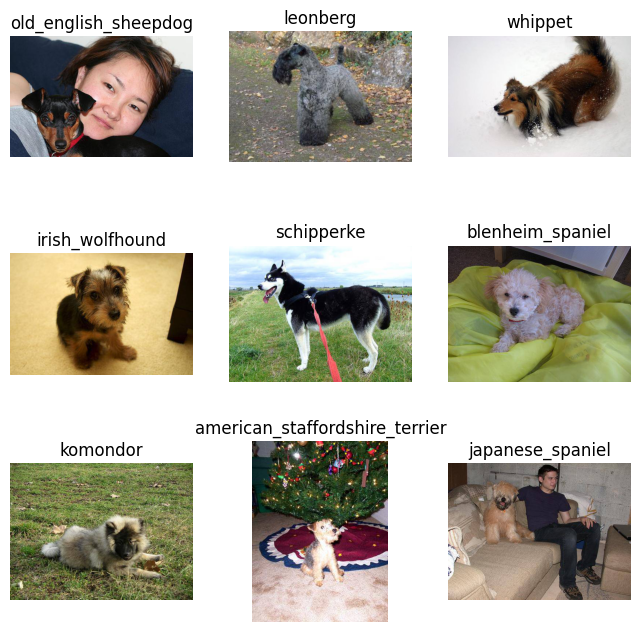

In [70]:
data_loaders.preview_data_sample(dataset);

In [71]:
dataset.labels_unique[99]

'whippet'

In [72]:
dataset.labels_unique


array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound',
       'shetland_sheepdog', 'walker_hound', 'maltese_dog',
       'norfolk_terrier', 'african_hunting_dog',
       'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier', 'boxer',
       'doberman', 'otterhound', 'standard_schnauzer',
       'irish_water_spaniel', 'black-and-tan_coonhound', 'cairn',
       'affenpinscher', 'labrador_retriever', 'ibizan_hound',
       'english_setter', 'weimaraner', 'giant_schnauzer', 'groenendael',
       'dhole', 'toy_poodle', 'border_terrier', 'tibetan_terrier',
       'norwegian_elkhound', 'shih-tzu', 'irish_terrier', 'kuvasz',
       'german_shepherd', 'greater_swiss_mountain_dog', 'basset',
       'australian_terrier', 'schipperke', 'rhodesian_ridgeback',
       'irish_setter', 'appenzeller', 'bloodhound', 'samoyed',
       'miniature_schnauzer', 'brittany_spaniel', 'kelpie', 'papillon',
       'borde